In [1]:
import os
import json
import numpy as np
import pandas as pd
from skimage.exposure import adjust_gamma
from sklearn.model_selection import train_test_split
from scipy import ndimage
from scipy.misc import imresize

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers


# load steering angles
angles = pd.read_csv('data/driving_log.csv', header=None)
angles.columns = ('Center Image', 'Left Image',
                  'Right Image', 'Steering Angle',
                  'Throttle', 'Brake', 'Speed')

angles = np.array(angles['Steering Angle'])


# Create arrays for center, right and left angles
images = np.asarray(os.listdir("data/IMG/"))
center = np.ndarray(shape=(len(angles), 20, 64, 3))
right = np.ndarray(shape=(len(angles), 20, 64, 3))
left = np.ndarray(shape=(len(angles), 20, 64, 3))

# Images are resized to 32x64 
# The top 12 pixels are cropped off
# Final image size is 20 x 64 x 3
count = 0
for image in images:
    image_file = os.path.join('data/IMG', image)
    if image.startswith('center'):
        image_data = ndimage.imread(image_file).astype(np.float32)
        center[count % len(angles)] = imresize(image_data, (32, 64, 3))[12:, :, :]
    elif image.startswith('right'):
        image_data = ndimage.imread(image_file).astype(np.float32)
        right[count % len(angles)] = imresize(image_data, (32, 64, 3))[12:, :, :]
    elif image.startswith('left'):
        image_data = ndimage.imread(image_file).astype(np.float32)
        left[count % len(angles)] = imresize(image_data, (32, 64, 3))[12:, :, :]
    count += 1


# Concatenate all arrays in to combined training dataset and labels
X_train = np.concatenate((center, right, left,), axis=0)
y_train = np.concatenate((angles, (angles - .08), (angles + .08)), axis=0)

# Adjust gamma in images to increase contrast
X_train = adjust_gamma(X_train)

# Create a mirror image of the images in the dataset to combat left turn bias
mirror = np.ndarray(shape=(X_train.shape))
count = 0
for i in range(len(X_train)):
    mirror[count] = np.fliplr(X_train[i])
    count += 1
mirror.shape

# Create mirror image labels
mirror_angles = y_train * -1

# Combine regular features/labels with mirror features/labels
X_train = np.concatenate((X_train, mirror), axis=0)
y_train = np.concatenate((y_train, mirror_angles), axis=0)
print('X_Training shape: {}'.format(X_train.shape))
print('Y_Training shape: {}'.format(y_train.shape))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.05)
print('X_Validation shape: {}'.format(X_val.shape))
print('Y_Validation shape: {}'.format(y_val.shape))

Using TensorFlow backend.


X_Training shape: (42468, 20, 64, 3)
Y_Training shape: (42468,)
X_Validation shape: (2124, 20, 64, 3)
Y_Validation shape: (2124,)


In [2]:
# Build network
# Nvidia architecture
model = Sequential()
model.add(BatchNormalization(axis=1, input_shape=(20, 64, 3)))
model.add(Convolution2D(16, 3, 3, border_mode='valid', subsample=(2, 2), activation='relu'))
model.add(Convolution2D(24, 3, 3, border_mode='valid', subsample=(1, 2), activation='relu'))
model.add(Convolution2D(36, 3, 3, border_mode='valid', activation='relu'))
model.add(Convolution2D(48, 2, 2, border_mode='valid', activation='relu'))
model.add(Convolution2D(48, 2, 2, border_mode='valid', activation='relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(.5))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))
model.summary()

model.compile(optimizer=optimizers.Adam(lr=1e-04), loss='mean_squared_error')

# Model will save the weights whenever validation loss improves
checkpoint = ModelCheckpoint(filepath ='model.h5', verbose =1, save_best_only=True,
                             monitor='val_loss')

# Discontinue training when validation loss fails to decrease
callback = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# Train model for 100 epochs and a batch size of 128
history = model.fit(X_train, y_train, nb_epoch=100, verbose=1, batch_size=128, shuffle=True, 
          validation_data=(X_val, y_val), callbacks=[checkpoint, callback])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 20, 64, 3)     80          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 9, 31, 16)     448         batchnormalization_1[0][0]       
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 7, 15, 24)     3480        convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 13, 36)     7812        convolution2d_2[0][0]            
___________________________________________________________________________________________

In [3]:
#print("Weights Saved")
json_string = model.to_json()
with open('model.json', 'w') as jsonfile:
    json.dump(json_string, jsonfile)
print("Model Saved")

Model Saved


dict_keys(['loss', 'val_loss'])
dict_keys(['loss', 'val_loss'])


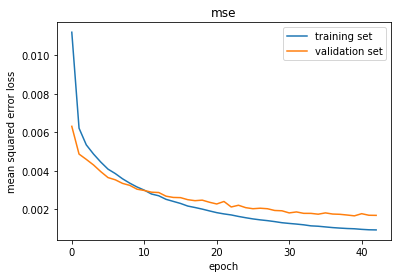

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
history_ = history.history
print(history_.keys())
np.save('history_origin.npy', history_)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('mse')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()